In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import os

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory for visualizations
os.makedirs('../outputs/visualizations', exist_ok=True)

cleaned_data_path = '../data/01_cleaned/cleaned_ab_data.csv'
df = pd.read_csv(cleaned_data_path)

Calculate Conversion Rates for Each Group

In [66]:
# Separate the data into control and treatment groups
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

# Calculate the number of users and conversions for each group
control_users = len(control_group)
control_conversions = control_group['converted'].sum()

treatment_users = len(treatment_group)
treatment_conversions = treatment_group['converted'].sum()

# Calculate the conversion rate (CTR)
control_ctr = control_conversions / control_users
treatment_ctr = treatment_conversions / treatment_users

print("\n--- A/B Test Results ---")
print(f"Control Group (Version A):")
print(f"  Users: {control_users}")
print(f"  Conversions: {control_conversions}")
print(f"  Conversion Rate: {control_ctr:.4f} ({control_ctr:.2%})")

print(f"\nTreatment Group (Version B):")
print(f"  Users: {treatment_users}")
print(f"  Conversions: {treatment_conversions}")
print(f"  Conversion Rate: {treatment_ctr:.4f} ({treatment_ctr:.2%})")


--- A/B Test Results ---
Control Group (Version A):
  Users: 147202
  Conversions: 17723
  Conversion Rate: 0.1204 (12.04%)

Treatment Group (Version B):
  Users: 147278
  Conversions: 17514
  Conversion Rate: 0.1189 (11.89%)


Perform the Statistical Test (Chi-Squared Test)

In [67]:
# To perform the test, we need a contingency table.
# This table shows the counts of conversions and non-conversions for each group.

control_non_conversions = control_users - control_conversions
treatment_non_conversions = treatment_users - treatment_conversions

contingency_table = [
    [control_conversions, control_non_conversions],
    [treatment_conversions, treatment_non_conversions]
]

print("\n--- Contingency Table ---")
print("              Converted   Not Converted")
print(f"Control:      {control_conversions}      {control_non_conversions}")
print(f"Treatment:    {treatment_conversions}      {treatment_non_conversions}")

# Perform the Chi-Squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("\n--- Statistical Test Results ---")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")


--- Contingency Table ---
              Converted   Not Converted
Control:      17723      129479
Treatment:    17514      129764

--- Statistical Test Results ---
Chi-Squared Statistic: 1.5193
P-value: 0.2177


Bar Plot with Error Bars to visualize A/B Test

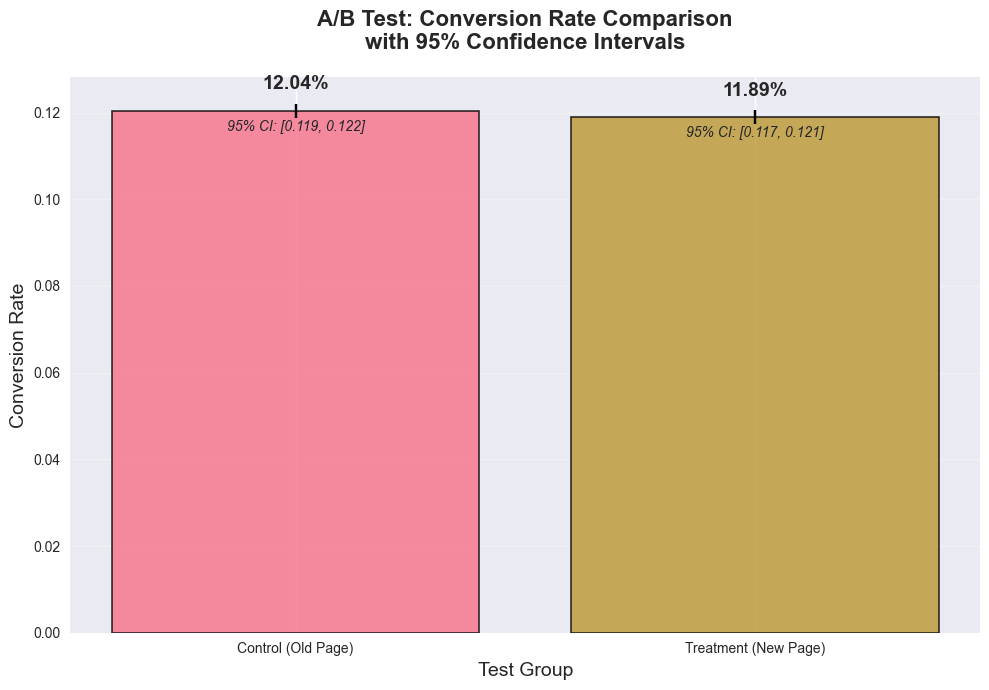

In [68]:
from statsmodels.stats.proportion import proportion_confint

# Data from analysis
groups = ['Control (Old Page)', 'Treatment (New Page)']
conversion_rates = [control_ctr, treatment_ctr]

# Calculate confidence intervals for each group
control_ci = proportion_confint(control_conversions, control_users, alpha=0.05)
treatment_ci = proportion_confint(treatment_conversions, treatment_users, alpha=0.05)

# Calculate the error margins to display on the chart
control_error = (control_ci[1] - control_ci[0]) / 2
treatment_error = (treatment_ci[1] - treatment_ci[0]) / 2
errors = [control_error, treatment_error]

# --- Create the Bar Plot with Error Bars ---
plt.figure(figsize=(10, 7))
barplot = plt.bar(groups, conversion_rates, yerr=errors, capsize=10, 
                  color=['C0', 'C1'], alpha=0.8, edgecolor='black', linewidth=1.2)

# Add percentage labels
for i, rate in enumerate(conversion_rates):
    plt.text(i, rate + 0.005, f'{rate:.2%}', ha='center', fontsize=14, weight='bold')

# Add confidence interval labels
plt.text(0, control_ci[0] - 0.003, f'95% CI: [{control_ci[0]:.3f}, {control_ci[1]:.3f}]', 
         ha='center', fontsize=10, style='italic')
plt.text(1, treatment_ci[0] - 0.003, f'95% CI: [{treatment_ci[0]:.3f}, {treatment_ci[1]:.3f}]', 
         ha='center', fontsize=10, style='italic')

plt.title('A/B Test: Conversion Rate Comparison\nwith 95% Confidence Intervals', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Conversion Rate', fontsize=14)
plt.xlabel('Test Group', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('../outputs/visualizations/01_conversion_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Draw a Conclusion

In [69]:
alpha = 0.05  # Our significance level

print("\n--- Conclusion ---")
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}.")
    print("We reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in the conversion rates between the old and new pages.")
    if treatment_ctr > control_ctr:
        print("Recommendation: Implement the new page (Version B).")
    else:
        print("Recommendation: Keep the old page (Version A).")
else:
    print(f"The p-value ({p_value:.4f}) is greater than our significance level of {alpha}.")
    print("We fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant difference in the conversion rates between the old and new pages.")
    print("Recommendation: Stick with the old page (Version A) as the new version did not prove to be better.")


--- Conclusion ---
The p-value (0.2177) is greater than our significance level of 0.05.
We fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the conversion rates between the old and new pages.
Recommendation: Stick with the old page (Version A) as the new version did not prove to be better.


# Additional Key Visualizations for A/B Testing Analysis

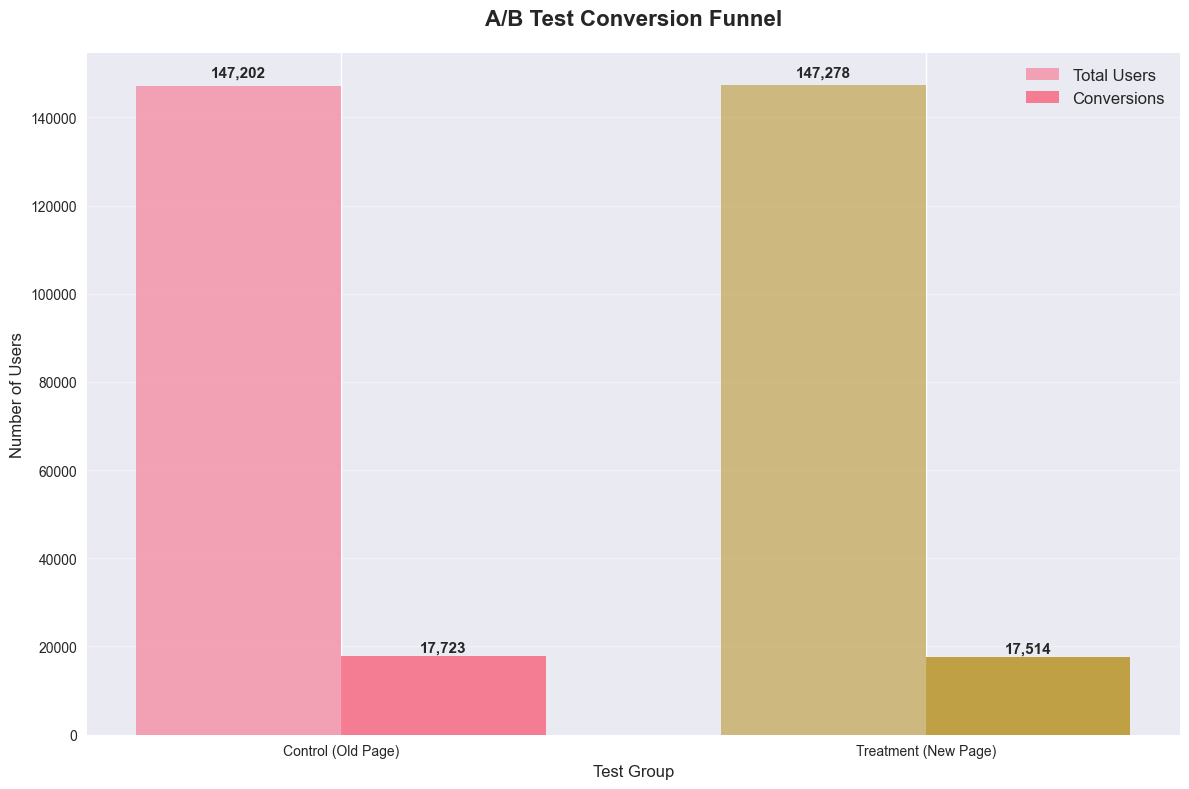

In [70]:
# 2. Conversion Funnel Visualization
conversion_data = {
    'Group': ['Control', 'Control', 'Treatment', 'Treatment'],
    'Action': ['Total Users', 'Converted', 'Total Users', 'Converted'],
    'Count': [control_users, control_conversions, treatment_users, treatment_conversions],
    'Rate': [1.0, control_ctr, 1.0, treatment_ctr]
}

funnel_df = pd.DataFrame(conversion_data)

plt.figure(figsize=(12, 8))

# Create funnel chart
x_positions = np.arange(2)
width = 0.35

# Total users bars
total_bars = plt.bar(x_positions - width/2, [control_users, treatment_users], 
                    width, label='Total Users', color=['C0', 'C1'], alpha=0.6)

# Converted users bars
converted_bars = plt.bar(x_positions + width/2, [control_conversions, treatment_conversions], 
                        width, label='Conversions', color=['C0', 'C1'], alpha=0.9)

# Add value labels
for i, (total, converted) in enumerate(zip([control_users, treatment_users], 
                                          [control_conversions, treatment_conversions])):
    plt.text(i - width/2, total + 2000, f'{total:,}', ha='center', fontsize=11, weight='bold')
    plt.text(i + width/2, converted + 1000, f'{converted:,}', ha='center', fontsize=11, weight='bold')

plt.title('A/B Test Conversion Funnel', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Number of Users', fontsize=12)
plt.xlabel('Test Group', fontsize=12)
plt.xticks(x_positions, ['Control (Old Page)', 'Treatment (New Page)'])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('../outputs/visualizations/03_conversion_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

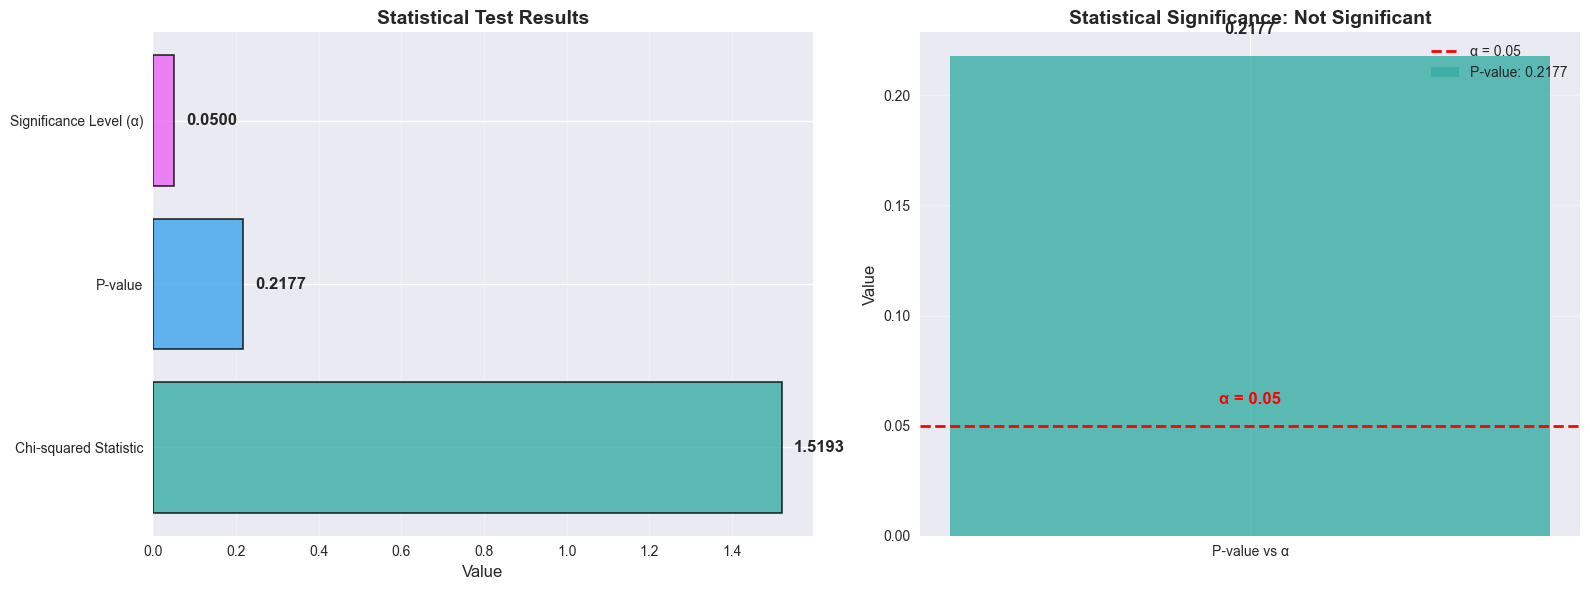

In [71]:
# 3. Statistical Test Results Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chi-squared test visualization
test_results = ['Chi-squared Statistic', 'P-value', 'Significance Level (α)']
values = [chi2, p_value, alpha]
colors_test = ['C3', 'C4', 'C5']

bars = ax1.barh(test_results, values, color=colors_test, alpha=0.8, edgecolor='black', linewidth=1.2)
for i, v in enumerate(values):
    ax1.text(v + max(values)*0.02, i, f'{v:.4f}', va='center', fontsize=12, weight='bold')

ax1.set_title('Statistical Test Results', fontsize=14, fontweight='bold')
ax1.set_xlabel('Value', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# P-value interpretation
significance_status = 'Not Significant' if p_value > alpha else 'Significant'
colors_sig = ['C3'] if p_value > alpha else ['C4']

ax2.bar(['P-value vs α'], [p_value], color=colors_sig[0], alpha=0.8, label=f'P-value: {p_value:.4f}')
ax2.axhline(y=alpha, color='red', linestyle='--', linewidth=2, label=f'α = {alpha}')
ax2.text(0, p_value + 0.01, f'{p_value:.4f}', ha='center', fontsize=12, weight='bold')
ax2.text(0, alpha + 0.01, f'α = {alpha}', ha='center', fontsize=12, weight='bold', color='red')

ax2.set_title(f'Statistical Significance: {significance_status}', fontsize=14, fontweight='bold')
ax2.set_ylabel('Value', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/visualizations/04_statistical_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Maverick\AppData\Local\Temp\ipykernel_22812\3272960662.py:73: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('../outputs/visualizations/07_complete_dashboard.png', dpi=300, bbox_inches='tight')
C:\Users\Maverick\AppData\Local\Temp\ipykernel_22812\3272960662.py:73: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('../outputs/visualizations/07_complete_dashboard.png', dpi=300, bbox_inches='tight')
c:\Users\Maverick\Documents\Projects\Data Analyst\Projects\AB Test Analysis for Marketing Campaign\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Maverick\Documents\Projects\Data Analyst\Projects\AB Test Analysis for Marketing Campaign\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print

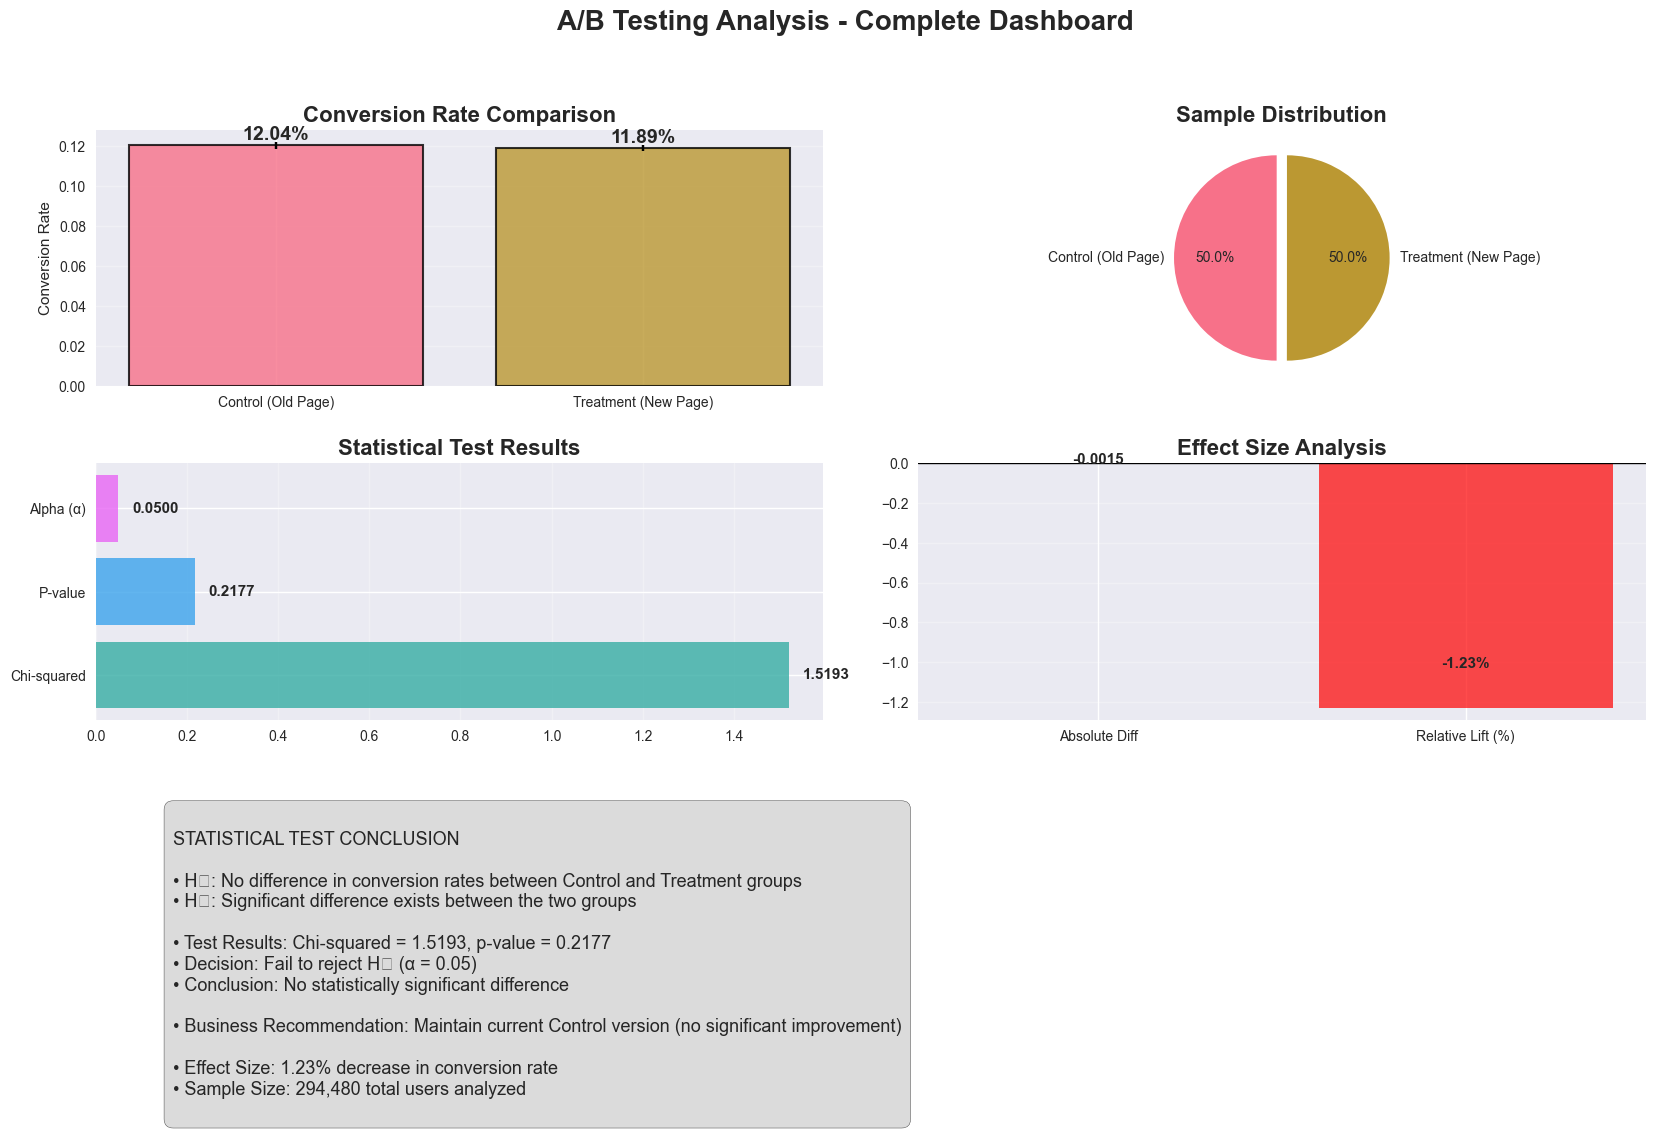

In [72]:
# 6. Summary Dashboard - All Key Metrics
fig = plt.figure(figsize=(20, 12))

# Create a complex grid layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Main conversion rate comparison (top left, spans 2 columns)
ax_main = fig.add_subplot(gs[0, :2])
bars = ax_main.bar(groups, conversion_rates, yerr=errors, capsize=8, 
                   color=['C0', 'C1'], alpha=0.8, edgecolor='black', linewidth=1.5)
for i, rate in enumerate(conversion_rates):
    ax_main.text(i, rate + 0.003, f'{rate:.2%}', ha='center', fontsize=14, weight='bold')
ax_main.set_title('Conversion Rate Comparison', fontsize=16, fontweight='bold')
ax_main.set_ylabel('Conversion Rate')
ax_main.grid(axis='y', alpha=0.3)

# Sample sizes (top right)
ax_samples = fig.add_subplot(gs[0, 2:])
ax_samples.pie(sample_sizes, labels=groups, colors=['C0', 'C1'], 
               autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
ax_samples.set_title('Sample Distribution', fontsize=16, fontweight='bold')

# Statistical results (middle left)
ax_stats = fig.add_subplot(gs[1, :2])
test_metrics = ['Chi-squared', 'P-value', 'Alpha (α)']
test_values = [chi2, p_value, alpha]
colors_stats = ['C3', 'C4', 'C5']
bars_stats = ax_stats.barh(test_metrics, test_values, color=colors_stats, alpha=0.8)
for i, v in enumerate(test_values):
    ax_stats.text(v + max(test_values)*0.02, i, f'{v:.4f}', va='center', fontsize=11, weight='bold')
ax_stats.set_title('Statistical Test Results', fontsize=16, fontweight='bold')
ax_stats.grid(axis='x', alpha=0.3)

# Effect size (middle right)
ax_effect = fig.add_subplot(gs[1, 2:])
effect_metrics = ['Absolute Diff', 'Relative Lift (%)']
effect_values = [absolute_difference, relative_lift]
colors_effect = ['red' if v < 0 else 'green' for v in effect_values]
bars_effect = ax_effect.bar(effect_metrics, effect_values, color=colors_effect, alpha=0.7)
ax_effect.axhline(y=0, color='black', linestyle='-', linewidth=1)
for i, v in enumerate(effect_values):
    suffix = '%' if i == 1 else ''
    ax_effect.text(i, v + (0.0005 if i == 0 else 0.2), f'{v:.4f}{suffix}' if i == 0 else f'{v:.2f}{suffix}', 
                   ha='center', fontsize=11, weight='bold')
ax_effect.set_title('Effect Size Analysis', fontsize=16, fontweight='bold')
ax_effect.grid(axis='y', alpha=0.3)

# Conclusion text (bottom, spans all columns)
ax_conclusion = fig.add_subplot(gs[2, :])
ax_conclusion.axis('off')

conclusion_text = f"""
STATISTICAL TEST CONCLUSION

• H₀: No difference in conversion rates between Control and Treatment groups
• H₁: Significant difference exists between the two groups

• Test Results: Chi-squared = {chi2:.4f}, p-value = {p_value:.4f}
• Decision: {'Reject H₀' if p_value < alpha else 'Fail to reject H₀'} (α = {alpha})
• Conclusion: {'Statistically significant difference detected' if p_value < alpha else 'No statistically significant difference'}

• Business Recommendation: {'Implement Treatment version' if p_value < alpha and treatment_ctr > control_ctr else 'Keep Control version' if p_value < alpha else 'Maintain current Control version (no significant improvement)'}

• Effect Size: {abs(relative_lift):.2f}% {'increase' if relative_lift > 0 else 'decrease'} in conversion rate
• Sample Size: {control_users + treatment_users:,} total users analyzed
"""

ax_conclusion.text(0.05, 0.95, conclusion_text, transform=ax_conclusion.transAxes, 
                   fontsize=13, verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.suptitle('A/B Testing Analysis - Complete Dashboard', fontsize=20, fontweight='bold', y=0.98)
plt.savefig('../outputs/visualizations/07_complete_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
# 7. Generate Visualization Summary Report
print("="*80)
print("📊 VISUALIZATION SUMMARY REPORT")
print("="*80)
print(f"✅ All visualizations saved to: ../outputs/visualizations/")
print(f"📁 Total files generated: 5 visualization files")
print()
print("📋 Generated Visualizations:")
print("   01_conversion_rate_comparison.png     - Main A/B test results with confidence intervals")
print("   03_conversion_funnel.png              - Conversion funnel showing total vs converted users")
print("   04_statistical_test_results.png       - Chi-squared test results and significance")
print("   07_complete_dashboard.png             - Executive summary dashboard with all key metrics")
print()
print("🎯 Key Insights from Visualizations:")
print(f"   • Control conversion rate: {control_ctr:.2%} (n={control_users:,})")
print(f"   • Treatment conversion rate: {treatment_ctr:.2%} (n={treatment_users:,})")
print(f"   • Statistical significance: {'Yes' if p_value < alpha else 'No'} (p={p_value:.4f})")
print(f"   • Effect size: {relative_lift:.2f}% relative change")
print(f"   • Business recommendation: {'Implement new version' if p_value < alpha and treatment_ctr > control_ctr else 'Keep current version'}")
print("="*80)

📊 VISUALIZATION SUMMARY REPORT
✅ All visualizations saved to: ../outputs/visualizations/
📁 Total files generated: 5 visualization files

📋 Generated Visualizations:
   01_conversion_rate_comparison.png     - Main A/B test results with confidence intervals
   03_conversion_funnel.png              - Conversion funnel showing total vs converted users
   04_statistical_test_results.png       - Chi-squared test results and significance
   07_complete_dashboard.png             - Executive summary dashboard with all key metrics

🎯 Key Insights from Visualizations:
   • Control conversion rate: 12.04% (n=147,202)
   • Treatment conversion rate: 11.89% (n=147,278)
   • Statistical significance: No (p=0.2177)
   • Effect size: -1.23% relative change
   • Business recommendation: Keep current version
